## AccelerateAI - Time Series Analysis and Forecasting

### Forecasting using LSTM

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv("monthly_milk_production.csv")

In [58]:
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


<AxesSubplot:>

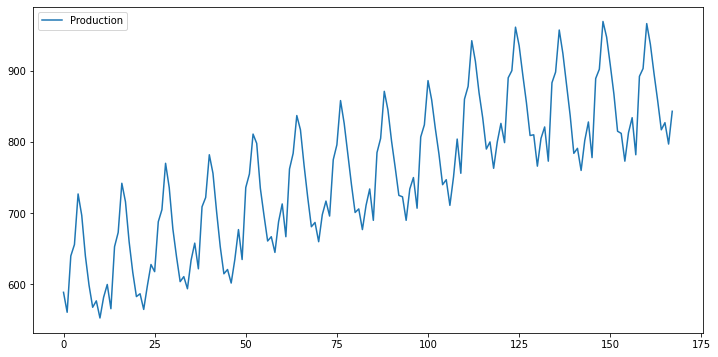

In [59]:
df.plot(figsize=(12,6))

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
results = seasonal_decompose(df['Production'])
results.plot();

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [16]:
len(df)

168

In [17]:
train = df.iloc[:156]
test = df.iloc[156:]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [20]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [7]:
#This class takes in a sequence of data-points gathered at equal intervals, 
# along with time series parameters such as stride, length of history, etc., 
# to produce batches for training/validation.

from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [23]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [24]:
X.shape

(1, 3, 1)

In [25]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [27]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fit model
model.fit(generator,epochs=10)

Epoch 1/10
144/144 [==============================] - 2s 4ms/step - loss: 0.0427
Epoch 2/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0226
Epoch 3/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0164
Epoch 4/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0129
Epoch 5/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0103
Epoch 6/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0063
Epoch 7/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0057
Epoch 8/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0069
Epoch 9/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 10/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0054


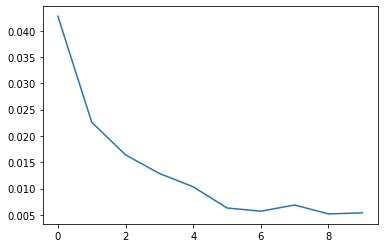

In [30]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
last_train_batch = scaled_train[-12:]

In [32]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [33]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 306ms/step


array([[0.6042459]], dtype=float32)

In [34]:
scaled_test[0]

array([0.67548077])

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [36]:
test_predictions

[array([0.6042459], dtype=float32),
 array([0.6509997], dtype=float32),
 array([0.7272447], dtype=float32),
 array([0.79137474], dtype=float32),
 array([0.8464722], dtype=float32),
 array([0.8556377], dtype=float32),
 array([0.81917864], dtype=float32),
 array([0.7327889], dtype=float32),
 array([0.66102254], dtype=float32),
 array([0.593125], dtype=float32),
 array([0.56568164], dtype=float32),
 array([0.5654216], dtype=float32)]

In [ ]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,813.303572
1975-02-01,782,809.682804
1975-03-01,892,879.037941
1975-04-01,903,912.407272
1975-05-01,966,954.157072


In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test['Predictions'] = true_predictions

C:\Users\sachi\AppData\Local\Temp\ipykernel_2104\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

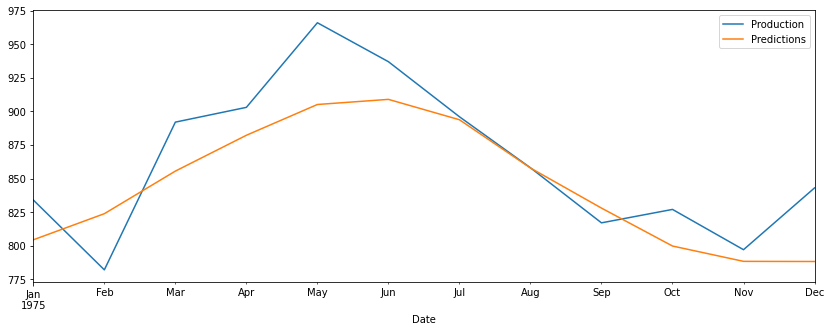

In [39]:
test.plot(figsize=(14,5))

In [40]:
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
mape=(mean_absolute_percentage_error(test['Production'],test['Predictions']))
print(mape)

0.03090057255158726


***